<a href="https://colab.research.google.com/github/KillerStrike17/DavidNet-Cifar10-Dawn-Benchmark/blob/main/Davidnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-lr-finder

In [ ]:
import torch
import matplotlib.pyplot as plt
torch.autograd.set_detect_anomaly(True)

torch.manual_seed(1)

batch_size = 512
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
show_summary = True
show_dataset_analyze = True

In [ ]:
# Load Network and Print Summary
from DeepLib.model import DavidNet
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()
use_cuda

True

In [ ]:
from DeepLib.dataset import get_loader
from DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


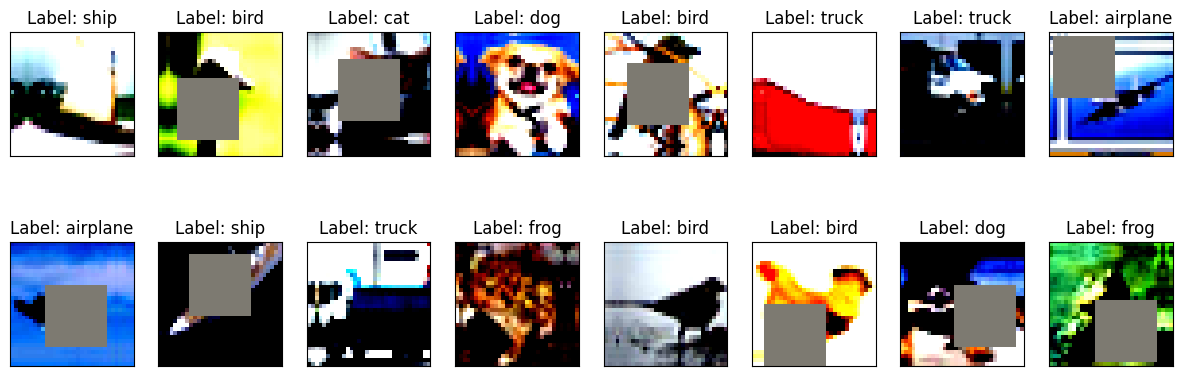

In [ ]:
# Calculate Class Scale
from DeepLib.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)#

In [ ]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer,get_adam_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
model = DavidNet(3,32).apply(initialize_weights).to(device)
print_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
         ResBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.07E-02


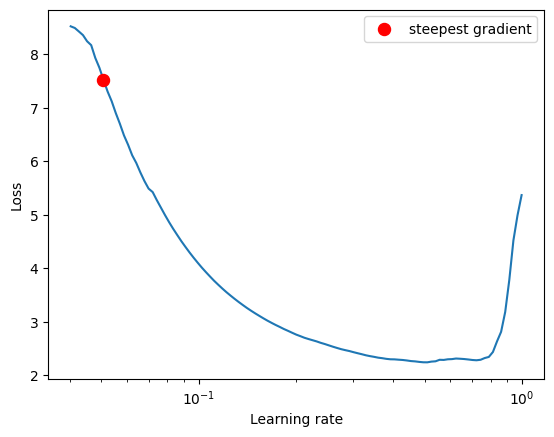

In [ ]:
from torch_lr_finder import LRFinder

criterion = torch.nn.CrossEntropyLoss()
optimizer = get_adam_optimizer(model, lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode = "exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:

# Train Params
epochs = 24
# lr =
max_lr = 5.07E-02
steps_per_epoch = len(train_loader)
dropout = False
momentum = 0.9
weight_decay = 1e-4

print("Using Device:", device)
print("Epochs:", epochs)
# print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

Using Device: cuda
Epochs: 24
Max Lr: 0.0507
Batch Size: 512
Dropout: False




In [ ]:
# optimizer = get_sgd_optimizer(model, lr=lr, weight_decay=weight_decay)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    anneal_strategy='linear'
)

# # One cycle schedule with a custom function
# custom_scheduler = one_cycle_lr_custom(
#     optimizer,
#     lr=lr,
#     max_lr=max_lr,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     anneal_strategy='linear'
# )




In [ ]:
trainer = Training(
    model,
    optimizer,
    pytorch_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    epochs,
    device,
    dropout
)

trainer.run()

| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.000507 | 00m 29s | 1.6265    |        22039 | 44.08  % | 1.523900 |       4995 | 49.95% |
|     2 | 0.010566 | 00m 29s | 1.384218  |        26774 | 53.55  % | 1.257620 |       5929 | 59.29% |
|     3 | 0.020625 | 00m 30s | 1.090993  |        31332 | 62.66  % | 1.067126 |       6481 | 64.81% |
|     4 | 0.030684 | 00m 29s | 0.933916  |        33714 | 67.43  % | 0.867857 |       7030 | 70.3 % |
|     5 | 0.040744 | 00m 30s | 0.89362   |        34429 | 68.86  % | 0.983632 |       6681 | 66.81% |
|     6 | 0.050673 | 00m 29s | 0.87178   |        34845 | 69.69  % | 0.935184 |       6761 | 67.61% |
|     7 | 0.048005 | 00m 28s | 0.842768  |        35330 | 70.66  % | 1.060011 |       6525 | 65.25% |
|     8 | 0.045336 | 00m 29s | 0.828912  |        35603 | 71.21  % | 0.823272 |       7236 | 72.36% |
|     9 | 0.042668 | 00m 30s | 0.801146  |        36055 | 72.11  % | 1.023354 |   

In [ ]:
# trainer.print_best_model()

In [ ]:
torch.save(model.state_dict(), 'savemodel.pth')

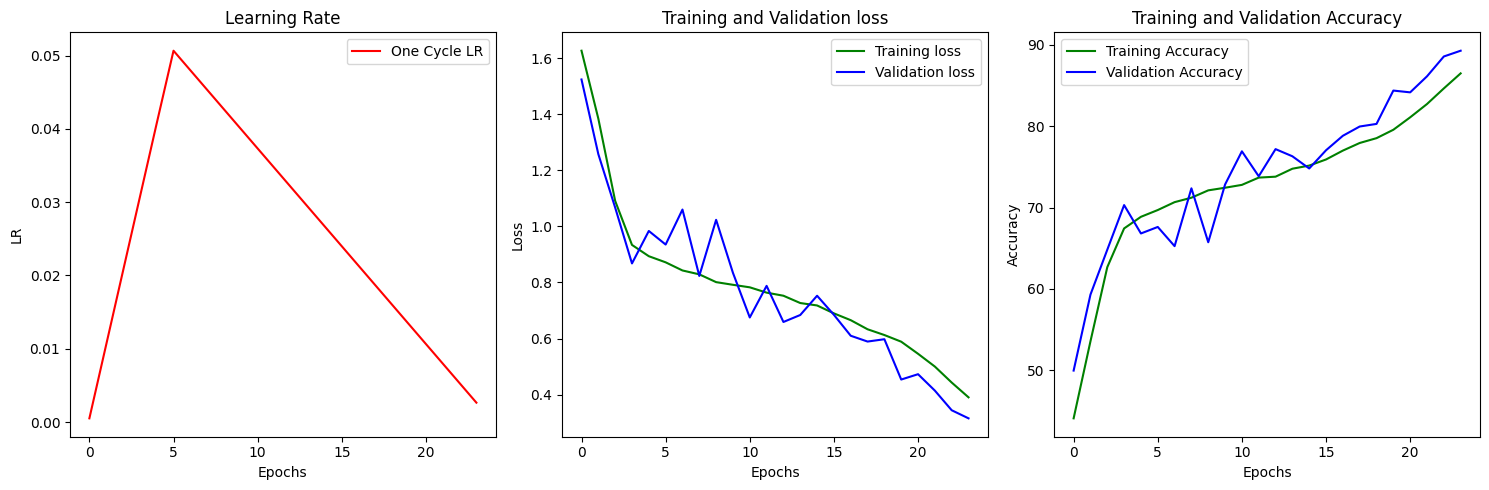

Confusion matrix, without normalization


Total Incorrect Predictions 1072


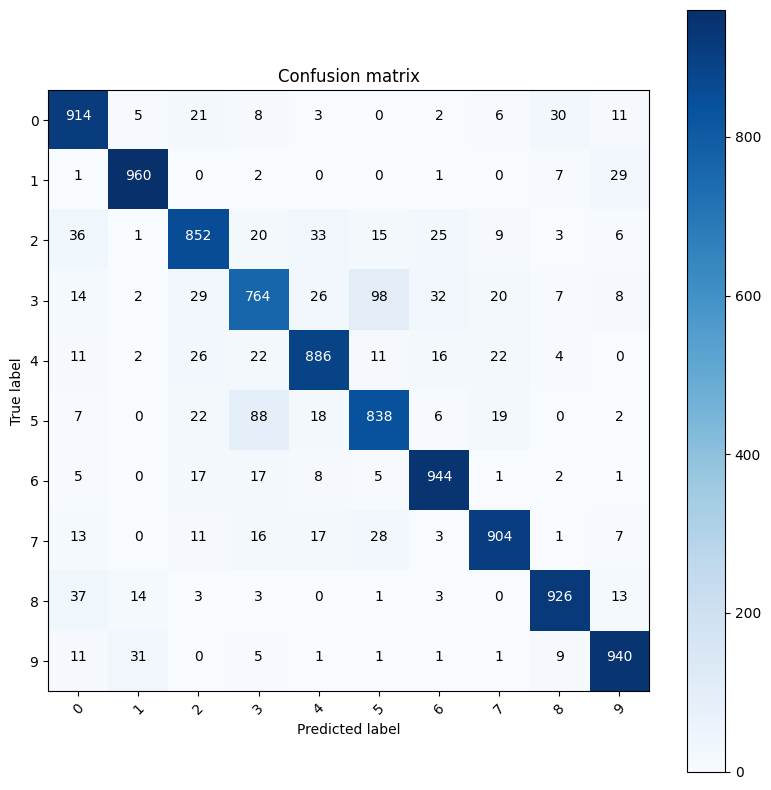

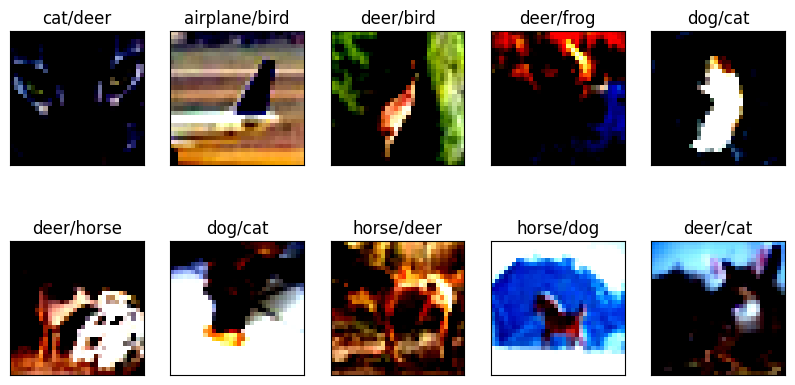

In [68]:
from DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.utils import get_incorrrect_predictions
from DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

### Pruning

In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))

<All keys matched successfully>

In [ ]:
# Show Model State Dictionary
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
prep.0.weight 	 torch.Size([64, 3, 3, 3])
prep.0.bias 	 torch.Size([64])
prep.1.weight 	 torch.Size([64])
prep.1.bias 	 torch.Size([64])
prep.1.running_mean 	 torch.Size([64])
prep.1.running_var 	 torch.Size([64])
prep.1.num_batches_tracked 	 torch.Size([])
l1X.0.weight 	 torch.Size([128, 64, 3, 3])
l1X.0.bias 	 torch.Size([128])
l1X.2.weight 	 torch.Size([128])
l1X.2.bias 	 torch.Size([128])
l1X.2.running_mean 	 torch.Size([128])
l1X.2.running_var 	 torch.Size([128])
l1X.2.num_batches_tracked 	 torch.Size([])
r1.block1.0.weight 	 torch.Size([128, 128, 3, 3])
r1.block1.0.bias 	 torch.Size([128])
r1.block1.1.weight 	 torch.Size([128])
r1.block1.1.bias 	 torch.Size([128])
r1.block1.1.running_mean 	 torch.Size([128])
r1.block1.1.running_var 	 torch.Size([128])
r1.block1.1.num_batches_tracked 	 torch.Size([])
r1.block2.0.weight 	 torch.Size([128, 128, 3, 3])
r1.block2.0.bias 	 torch.Size([128])
r1.block2.1.weight 	 torch.Size([128])
r1.block2.1.bias 	 torch.Size([128])


In [ ]:
def get_total_parameters_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [ ]:
total_params_count = get_pruned_parameters_count(model)
print('Total parameters:', total_params_count)

Total parameters: 6575370


In [ ]:
pruned_model.prep

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
from torch.nn.utils import prune
def prune_my_model(pruned_model,pruning_percentage):
  pruning_percenatage = pruning_percentage
  parameters_to_prune = (
      (pruned_model.prep[0], 'weight'),
      (pruned_model.l1X[0], 'weight'),
      (pruned_model.r1.block1[0], 'weight'),
      (pruned_model.r1.block2[0], 'weight'),
      (pruned_model.l2X[0], 'weight'),
      (pruned_model.l3X[0], 'weight'),
      (pruned_model.r2.block1[0], 'weight'),
      (pruned_model.r2.block2[0], 'weight'),
      (pruned_model.fc1, 'weight'),
  )
  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=pruning_percenatage, # Specifying the percentage
  )

  prune.remove(pruned_model.prep[0], 'weight')
  prune.remove(pruned_model.l1X[0], 'weight')
  prune.remove(pruned_model.r1.block1[0], 'weight')
  prune.remove(pruned_model.r1.block2[0], 'weight')
  prune.remove(pruned_model.l2X[0], 'weight')
  prune.remove(pruned_model.l3X[0], 'weight')
  prune.remove(pruned_model.r2.block1[0], 'weight')
  prune.remove(pruned_model.r2.block2[0], 'weight')
  prune.remove(pruned_model.fc1, 'weight')

  pruned_model_param_count = get_pruned_parameters_count(pruned_model)
  print('Original Model paramete count:', total_params_count)
  print('Pruned Model parameter count:', pruned_model_param_count)
  print(f'Compressed Percentage: {(100 - (pruned_model_param_count / total_params_count) * 100)}%')
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          outputs = pruned_model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the Pruned Model on the 10000 test images:', (
      100 * correct / total))
  # print('Accuracy of the Original Model on the 10000 test images', accuracy)

In [ ]:
loss,correct = test(model, test_loader, device)

print('Accuracy of the Original Model on the 10000 test images:', (
    correct / 10000))

Accuracy of the Original Model on the 10000 test images: 0.8928


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.68)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_68.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 2108695
Compressed Percentage: 67.93039783312574%
Accuracy of the Pruned Model on the 10000 test images: 88.38


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.7)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_70.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 1977322
Compressed Percentage: 69.92835384168495%
Accuracy of the Pruned Model on the 10000 test images: 88.33


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.75)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_75.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 1648890
Compressed Percentage: 74.92323625894817%
Accuracy of the Pruned Model on the 10000 test images: 88.48


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.9)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_90.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 663594
Compressed Percentage: 89.9078835107378%
Accuracy of the Pruned Model on the 10000 test images: 88.46


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.99)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_99.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 72416
Compressed Percentage: 98.89867794511945%
Accuracy of the Pruned Model on the 10000 test images: 74.58


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.97)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_97.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 203789
Compressed Percentage: 96.90072193656022%
Accuracy of the Pruned Model on the 10000 test images: 85.64


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.95)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_95.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 335162
Compressed Percentage: 94.902765928001%
Accuracy of the Pruned Model on the 10000 test images: 87.77


In [ ]:
import numpy as np
for _ in np.arange(0.9,1,0.01):
  pruned_model = DavidNet()
  pruned_model.load_state_dict(torch.load('savemodel.pth'))
  prune_my_model(pruned_model,pruning_percentage=round(_,2))
  torch.save(pruned_model.state_dict(), f'pruned_savemodel_{round(_,2)}.pth')
  # print(round(_,2))

Original Model paramete count: 6575370
Pruned Model parameter count: 663594
Compressed Percentage: 89.9078835107378%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the Pruned Model on the 10000 test images: 88.22
Original Model paramete count: 6575370
Pruned Model parameter count: 597908
Compressed Percentage: 90.90685391088257%
Accuracy of the Pruned Model on the 10000 test images: 88.45
Original Model paramete count: 6575370
Pruned Model parameter count: 532221
Compressed Percentage: 91.90583951929702%
Accuracy of the Pruned Model on the 10000 test images: 88.44
Original Model paramete count: 6575370
Pruned Model parameter count: 466535
Compressed Percentage: 92.90480991944179%
Accuracy of the Pruned Model on the 10000 test images: 88.22
Original Model paramete count: 6575370
Pruned Model parameter count: 400848
Compressed Percentage: 93.90379552785623%
Accuracy of the Pruned Model on the 10000 test images: 88.19
Original Model paramete count: 6575370
Pruned Model parameter count: 335162
Compressed Percentage: 94.902765928001%
Accuracy of the Pruned Model on the 10000 test images: 87.86
Original Model paramete count: 6575370
Pruned 

In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.5)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_0.5.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 3291050
Compressed Percentage: 49.948824172632115%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the Pruned Model on the 10000 test images: 88.45


In [ ]:
# Loading a model to a seperate classifier
pruned_model = DavidNet()
pruned_model.load_state_dict(torch.load('savemodel.pth'))
prune_my_model(pruned_model,pruning_percentage=0.60)
torch.save(pruned_model.state_dict(), 'pruned_savemodel_0.60.pth')

Original Model paramete count: 6575370
Pruned Model parameter count: 2634186
Compressed Percentage: 59.938589007158534%
Accuracy of the Pruned Model on the 10000 test images: 88.28


In [66]:
from google.colab import files
files.download('pruned_savemodel_60.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
from google.colab import files
files.download('pruned_savemodel_68.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Quantization

In [ ]:
num_calibration_batches = 512

In [ ]:
def load_model(model_file):
    model = DavidNet(3,32)
    state_dict = torch.load(model_file)
    model.load_state_dict(state_dict)
    model.to('cpu')
    return model

In [ ]:
myModel = load_model('savemodel.pth').to("cpu")
myModel.eval()

DavidNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l1X): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (r1): ResBlock(
    (block1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (l2X): Sequential(
    (0): Conv2d(128, 256, 

In [ ]:
myModel.qconfig = torch.quantization.get_default_qconfig('fbgemm')

In [ ]:
torch.quantization.prepare(myModel, inplace = True)
torch.quantization.convert(myModel, inplace = True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:1209: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


DavidNet(
  (prep): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l1X): Sequential(
    (0): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (r1): ResBlock(
    (block1): Sequential(
      (0): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (1): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): Sequential(
      (0): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
     

In [ ]:
torch.save(myModel.state_dict(), 'quant_savemodel.pt')

In [ ]:
# eval_batch_size = 512
# num_eval_batches = 1

In [ ]:
# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self, name, fmt=':f'):
#         self.name = name
#         self.fmt = fmt
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count

#     def __str__(self):
#         fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
#         return fmtstr.format(**self.__dict__)

In [ ]:
# def evaluate(model, criterion, data_loader, neval_batches):
#     model.eval()
#     top1 = AverageMeter('Acc@1', ':6.2f')
#     top5 = AverageMeter('Acc@5', ':6.2f')
#     cnt = 0
#     with torch.no_grad():
#         for image, target in data_loader:
#             output = model(image)
#             loss = criterion(output, target)
#             cnt += 1
#             acc1, acc5 = accuracy(output, target, topk=(1, 5))
#             print('.', end = '')
#             top1.update(acc1[0], image.size(0))
#             top5.update(acc5[0], image.size(0))
#             if cnt >= neval_batches:
#                  return top1, top5

#     return top1, top5

In [ ]:
# top1, top5 = evaluate(model, criterion, test_loader, neval_batches=512)
# print('Evaluation accuracy on %d images, %2.2f'%(num_eval_batches * eval_batch_size, top1.avg))